# Проект по дисциплине "Машинное обучение и большие данные" 
Подготовили: Кабанов Илья и Мухамедьянов Айнур, группа 22П-2

Цель: Реализовать качественные модели для определения типа жилья и стоимости на основе датасета с жильем в Турции

### План работы:
__1__ Определить необходимые поля и создать структуру набора данных. Определить, какие атрибуты имеют наибольшее влияние на цену и оставить только их для последующего обучения.

__2__ Провести предварительную обработку датасета: очистка данных от пустых и аномальных значений. Написать функцию перевода в TRY, перевести дату в нормальный вид, функция обработки +(плюса) и пустых кв/м, заполнить Na.

__3__ Провести визуальный анализ данных

__4__ Экспортировать обработанный датасет в csv для Dashboard

__5__ Обучить модели и сохранить лучшую из них


## 1. Подключение библиотек и импорт данных

In [8]:
pip install pymorphy3

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [163]:
import pandas as pd
import string
import re
import nltk
import pymorphy3
import numpy as np

In [447]:
df = pd.read_csv('real_estate_data.csv')

/var/folders/32/xtjj24594yn8c0xqz_lg7xv80000gn/T/ipykernel_2638/2314456965.py:1: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_estate_data.csv')


In [449]:
df

,id,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,furnished,heating_type,price,price_currency
0,1,Konut,Rezidans,12/10/18,1/9/19,2,30,0,20 ve üzeri,2,2+1,90.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,3500.0,TRY
1,2,Konut,Daire,2/13/19,NaN,1,14,0,20 ve üzeri,20 ve üzeri,1+0,43.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,490000.0,TRY
2,3,Konut,Daire,10/9/18,11/8/18,1,30,0,1,Yüksek Giriş,2+1,NaN,Tekirdağ/Çorlu/Reşadiye,NaN,Fancoil,155000.0,TRY
3,4,Konut,Rezidans,9/10/18,10/10/18,1,30,3,20 ve üzeri,20 ve üzeri,6+1,450.0,İstanbul/Beşiktaş/Levent,NaN,Fancoil,32500000.0,TRY
4,5,Konut,Rezidans,12/10/18,1/9/19,1,30,0,20 ve üzeri,2,2+1,90.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,1450000.0,TRY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403482,403483,Konut,Daire,9/18/18,NaN,2,162,NaN,NaN,NaN,+,NaN,İstanbul/Sultanbeyli/Adil,NaN,NaN,1500.0,TRY
403483,403484,Konut,Daire,10/11/18,NaN,1,139,NaN,NaN,NaN,2+1,NaN,Sakarya/Adapazarı/Cumhuriyet,NaN,NaN,120000.0,TRY
403484,403485,Konut,Daire,11/22/18,NaN,1,97,NaN,NaN,NaN,1+1,NaN,Antalya/Alanya/Saray,NaN,NaN,48000.0,EUR
403485,403486,Konut,Daire,2/21/19,NaN,2,6,NaN,NaN,NaN,2+1,2.0,Aydın/Kuşadası/Türkmen,NaN,NaN,900.0,TRY


### Описание набора данных

In [452]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403487 entries, 0 to 403486
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 403487 non-null  int64  
 1   type               403487 non-null  object 
 2   sub_type           403487 non-null  object 
 3   start_date         403487 non-null  object 
 4   end_date           266298 non-null  object 
 5   listing_type       403487 non-null  int64  
 6   tom                403487 non-null  int64  
 7   building_age       376097 non-null  object 
 8   total_floor_count  375466 non-null  object 
 9   floor_no           368191 non-null  object 
 10  room_count         403487 non-null  object 
 11  size               257481 non-null  float64
 12  address            403487 non-null  object 
 13  furnished          0 non-null       float64
 14  heating_type       375517 non-null  object 
 15  price              402772 non-null  float64
 16  pr

### Признаки (Описание)


- type (Тип недвижимости) 
- sub_type (подгруппа по типу недвижимости)
- start_date (дата, когда листинг начинает действовать на рынке)
- end_date (дата, когда листинг больше не активен на рынке)
- listing_type (Тип объявления)
- tom (Время выхода на рынок)
- building_age (Возраст здания)
- total_floor_count (Общее количество этажей в здании)
- room_count (Количество комнат в квартире)
- size (Размер дома)
- address (Адрес жилого помещения)
- furnished (-)
- currency (Валюта цены на жилье)
- floor_no (Информация о номере этажа в данном объявлении)
- price (Стоимость дома)
- heating_type (Различные типы систем отопления)

## 2. Предварительная обработка данных

In [456]:
# Проверка на дубликаты
df.duplicated().sum()  

0

In [457]:
# Проверка на пустые значения
df.isna().sum()

id                        0
type                      0
sub_type                  0
start_date                0
end_date             137189
listing_type              0
tom                       0
building_age          27390
total_floor_count     28021
floor_no              35296
room_count                0
size                 146006
address                   0
furnished            403487
heating_type          27970
price                   715
price_currency          715
dtype: int64

In [458]:
# Заполнение средними значениями пустые size и building_age
df['size'] = df['size'].fillna(df['size'].mean())
df['building_age'] = pd.to_numeric(df['building_age'], errors='coerce')
df['building_age'] = df['building_age'].fillna(df['building_age'].mean())

In [460]:
df.isna().sum()

id                        0
type                      0
sub_type                  0
start_date                0
end_date             137189
listing_type              0
tom                       0
building_age              0
total_floor_count     28021
floor_no              35296
room_count                0
size                      0
address                   0
furnished            403487
heating_type          27970
price                   715
price_currency          715
dtype: int64

In [462]:
df['total_floor_count'].unique()

array(['20 ve üzeri', '1', '10-20 arası', '4', '2', '3', '8', '7', '6',
       '5', '10', nan, '9'], dtype=object)

In [463]:
# Заменим диапазоны на среднее значение
df['total_floor_count'] = df['total_floor_count'].str.replace(' ve üzeri', '')
df['total_floor_count'] = df['total_floor_count'].str.replace('10-20 arası', '15')
df['total_floor_count'] = df['total_floor_count'].str.replace('6-10 arası', '8')
df['total_floor_count'] = df['total_floor_count'].fillna('0').astype(int)

In [465]:
df['total_floor_count'].unique()

array([20,  1, 15,  4,  2,  3,  8,  7,  6,  5, 10,  0,  9])

In [468]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403487 entries, 0 to 403486
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 403487 non-null  int64  
 1   type               403487 non-null  object 
 2   sub_type           403487 non-null  object 
 3   start_date         403487 non-null  object 
 4   end_date           266298 non-null  object 
 5   listing_type       403487 non-null  int64  
 6   tom                403487 non-null  int64  
 7   building_age       403487 non-null  float64
 8   total_floor_count  403487 non-null  int64  
 9   floor_no           368191 non-null  object 
 10  room_count         403487 non-null  object 
 11  size               403487 non-null  float64
 12  address            403487 non-null  object 
 13  furnished          0 non-null       float64
 14  heating_type       375517 non-null  object 
 15  price              402772 non-null  float64
 16  pr

In [469]:
df.isna().sum()

id                        0
type                      0
sub_type                  0
start_date                0
end_date             137189
listing_type              0
tom                       0
building_age              0
total_floor_count         0
floor_no              35296
room_count                0
size                      0
address                   0
furnished            403487
heating_type          27970
price                   715
price_currency          715
dtype: int64

In [474]:
df['end_date'] = df['end_date'].fillna('01/09/25')

In [481]:
df.isna().sum()

id                        0
type                      0
sub_type                  0
start_date                0
end_date                  0
listing_type              0
tom                       0
building_age              0
total_floor_count         0
floor_no              35296
room_count                0
size                      0
address                   0
furnished            403487
heating_type          27970
price                   715
price_currency          715
dtype: int64

In [482]:
df['floor_no'].unique()

array(['2', '20 ve üzeri', 'Yüksek Giriş', '10', '14', nan, 'Kot 2',
       'Asma Kat', 'Bahçe katı', '11', '3', '13', '7', '16', 'Müstakil',
       'Zemin Kat', '19', '4', '5', 'En Üst Kat', '8', '15', '1',
       'Giriş Katı', '9', 'Çatı Katı', '12', '17', '6', 'Kot 4', 'Kot 1',
       'Kot 3', '18', 'Teras Kat', 'Komple', 'Bodrum Kat', 1, 2, 3, 12, 4,
       5, 6, 7, 8], dtype=object)

In [485]:
df['floor_no'] = df['floor_no'].str.replace('Kot ', '')
df['floor_no'] = df['floor_no'].str.replace(' ve üzeri', '')
df['floor_no'] = df['floor_no'].str.replace('Yüksek Giriş', '10')
df['floor_no'] = df['floor_no'].str.replace('Asma Kat', '1')
df['floor_no'] = df['floor_no'].str.replace('Bahçe katı', '4')
df['floor_no'] = df['floor_no'].str.replace('Müstakil', '7')
df['floor_no'] = df['floor_no'].str.replace('Zemin Kat', '1')
df['floor_no'] = df['floor_no'].str.replace('En Üst Kat', '10')
df['floor_no'] = df['floor_no'].str.replace('Giriş Katı', '3')
df['floor_no'] = df['floor_no'].str.replace('Çatı Katı', '4')
df['floor_no'] = df['floor_no'].str.replace('Teras', '1')
df['floor_no'] = df['floor_no'].str.replace('Komple', '6')
df['floor_no'] = df['floor_no'].str.replace('Bodrum Kat', '1')
df['floor_no'] = df['floor_no'].str.replace(' Kat', '')
df['floor_no'] = df['floor_no'].fillna('0').astype(int)

In [486]:
df['floor_no'].unique()

array([ 2, 20, 10, 14,  0,  1,  4, 11,  3, 13,  7, 16, 19,  5,  8, 15,  9,
       12, 17,  6, 18])

In [487]:
df.isna().sum()

id                        0
type                      0
sub_type                  0
start_date                0
end_date                  0
listing_type              0
tom                       0
building_age              0
total_floor_count         0
floor_no                  0
room_count                0
size                      0
address                   0
furnished            403487
heating_type          27970
price                   715
price_currency          715
dtype: int64

In [488]:
df['heating_type'].unique()

array(['Fancoil', 'Yok', 'Kalorifer (Doğalgaz)', 'Kalorifer (Kömür)',
       'Kombi (Elektrikli)', 'Klima', 'Kombi (Doğalgaz)',
       'Merkezi Sistem (Isı Payı Ölçer)', 'Merkezi Sistem',
       'Soba (Kömür)', 'Yerden Isıtma', 'Soba (Doğalgaz)',
       'Güneş Enerjisi', 'Kalorifer (Akaryakıt)', 'Jeotermal',
       'Kat Kaloriferi', nan], dtype=object)

In [489]:
df['heating_type'] = df['heating_type'].fillna('absent')

In [490]:
df['price'] = df['price'].fillna(df['price'].mean())

In [491]:
df['price'] = df['price'].astype(int)
df['size'] = df['size'].astype(int)
df['building_age'] = df['building_age'].astype(int)

In [494]:
df.isna().sum()

id                        0
type                      0
sub_type                  0
start_date                0
end_date                  0
listing_type              0
tom                       0
building_age              0
total_floor_count         0
floor_no                  0
room_count                0
size                      0
address                   0
furnished            403487
heating_type              0
price                     0
price_currency          715
dtype: int64

In [500]:
df['price_currency'].unique()

array(['TRY', 'GBP', 'EUR', 'USD', nan], dtype=object)

In [502]:
# Конвертация цен в единую валюту TRY
def convert_to_tru(df, exchange_rates):
    df = df.copy()
    df['price'] = df['price'].astype(float)
    for currency, rate in exchange_rates.items():
        mask = df['price_currency'] == currency
        df.loc[mask, 'price'] = df.loc[mask, 'price'] * float(rate)
        df.loc[mask, 'price_currency'] = 'TRU'
    return df

exchange_rates = {
    'EUR': 47.91,
    'USD': 41.16,
    'GBP': 55.08
}
df = convert_to_tru(df, exchange_rates)

In [504]:
# Удаление не нужных столбцов
df.drop('furnished', axis=1, inplace=True)
df.drop('price_currency', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.drop('type', axis=1, inplace=True)

In [506]:
df.isna().sum()

sub_type             0
start_date           0
end_date             0
listing_type         0
tom                  0
building_age         0
total_floor_count    0
floor_no             0
room_count           0
size                 0
address              0
heating_type         0
price                0
dtype: int64

In [507]:
# Перевод в тип данных datetime
df['start_date'] = pd.to_datetime(df['start_date'], format='mixed', dayfirst=True)
df['end_date'] = pd.to_datetime(df['end_date'], format='mixed', dayfirst=True)

In [510]:
df[df['room_count'] == '+'].count()

sub_type             2898
start_date           2898
end_date             2898
listing_type         2898
tom                  2898
building_age         2898
total_floor_count    2898
floor_no             2898
room_count           2898
size                 2898
address              2898
heating_type         2898
price                2898
dtype: int64

In [512]:
# Парсинг количества комнат
def parse_room_count(value):
    if pd.isna(value) or value == '+' or value == '' or value == 0:
        return 1
    parts = str(value).split('+')
    total = sum(int(part) for part in parts if part.isdigit())
    if total == 20:
        return 1
    return total
    
df['room_count'] = df['room_count'].apply(parse_room_count)

In [514]:
df[df['size'] < 20].count().sum()

6409

In [517]:
df[df['price'] < 0].count().sum()

13

In [519]:
# Удаление аномальных значений
indices_to_drop = df[(df['size'] < 20) | (df['price'] < 0)].index
df = df.drop(indices_to_drop)
indices_to_drop = df[(df['price'] > 500000)].index
df = df.drop(indices_to_drop)
indices_to_drop = df[(df['size'] > 6000)].index
df = df.drop(indices_to_drop)
indices_to_drop = df[(df['listing_type'] == 3)].index
df = df.drop(indices_to_drop)

In [521]:
df.describe()

,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,price
count,347108,347108,347108.000000,347108.000000,347108.00000,347108.000000,347108.000000,347108.000000,347108.000000,347108.000000
mean,2018-10-28 22:41:18.601472512,2021-03-11 03:18:50.193484032,1.328581,55.802891,1.05082,5.343562,2.896931,3.531330,174.875180,170050.822423
min,2018-01-09 00:00:00,2018-01-09 00:00:00,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,20.000000,0.000000
25%,2018-09-15 00:00:00,2018-11-29 00:00:00,1.000000,27.000000,0.00000,3.000000,0.000000,3.000000,95.000000,1750.000000
50%,2018-10-30 00:00:00,2019-02-16 00:00:00,1.000000,36.000000,1.00000,4.000000,2.000000,4.000000,140.000000,175000.000000
75%,2018-12-27 00:00:00,2025-09-01 00:00:00,2.000000,88.000000,1.00000,6.000000,4.000000,4.000000,279.000000,275000.000000
max,2019-12-02 00:00:00,2025-09-01 00:00:00,2.000000,180.000000,5.00000,20.000000,20.000000,14.000000,6000.000000,500000.000000
std,NaN,NaN,0.469698,43.928339,1.22327,4.028339,3.501581,0.983109,101.534434,144519.163749


In [523]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['address_encoded'] = le.fit_transform(df['address'])
df = df.drop('address', axis=1)

In [525]:
df

,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,heating_type,price,address_encoded
0,Rezidans,2018-10-12,2019-09-01,2,30,0,20,2,3,90,Fancoil,3500.0,6301
1,Daire,2019-02-13,2025-09-01,1,14,0,20,20,1,43,Fancoil,490000.0,6301
2,Daire,2018-09-10,2018-08-11,1,30,0,1,10,3,279,Fancoil,155000.0,5314
6,Daire,2019-04-01,2025-09-01,2,54,0,20,14,4,160,Fancoil,3750.0,6301
11,Rezidans,2019-05-01,2019-01-18,2,13,2,20,20,4,165,Fancoil,7500.0,6703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403480,Daire,2018-09-25,2019-01-23,1,120,1,0,0,4,279,absent,185000.0,1165
403481,Daire,2019-12-01,2025-09-01,1,46,1,0,0,1,279,absent,354641.0,7096
403482,Daire,2018-09-18,2025-09-01,2,162,1,0,0,1,279,absent,1500.0,6477
403483,Daire,2018-11-10,2025-09-01,1,139,1,0,0,3,279,absent,120000.0,4838


In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 347108 entries, 0 to 403486
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   sub_type           347108 non-null  object        
 1   start_date         347108 non-null  datetime64[ns]
 2   end_date           347108 non-null  datetime64[ns]
 3   listing_type       347108 non-null  int64         
 4   tom                347108 non-null  int64         
 5   building_age       347108 non-null  int64         
 6   total_floor_count  347108 non-null  int64         
 7   floor_no           347108 non-null  int64         
 8   room_count         347108 non-null  int64         
 9   size               347108 non-null  int64         
 10  heating_type       347108 non-null  object        
 11  price              347108 non-null  float64       
 12  address_encoded    347108 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(8), objec

__Мы провели предобработку нашего датасета.__ 

Наш датасет содержит 347108 наблюдений с 13 признаками.

Удалили аномальные значения, заполнили пустые значения признаков [prise, size, building_age] средними значениями. 

Удалили строчки с пустыми значениями в признаках, где незначитальна потеря данных. 

Перевели даты в тип данных datetime и провели пасринг количества комнат.


## 3. Визуальный анализ данных

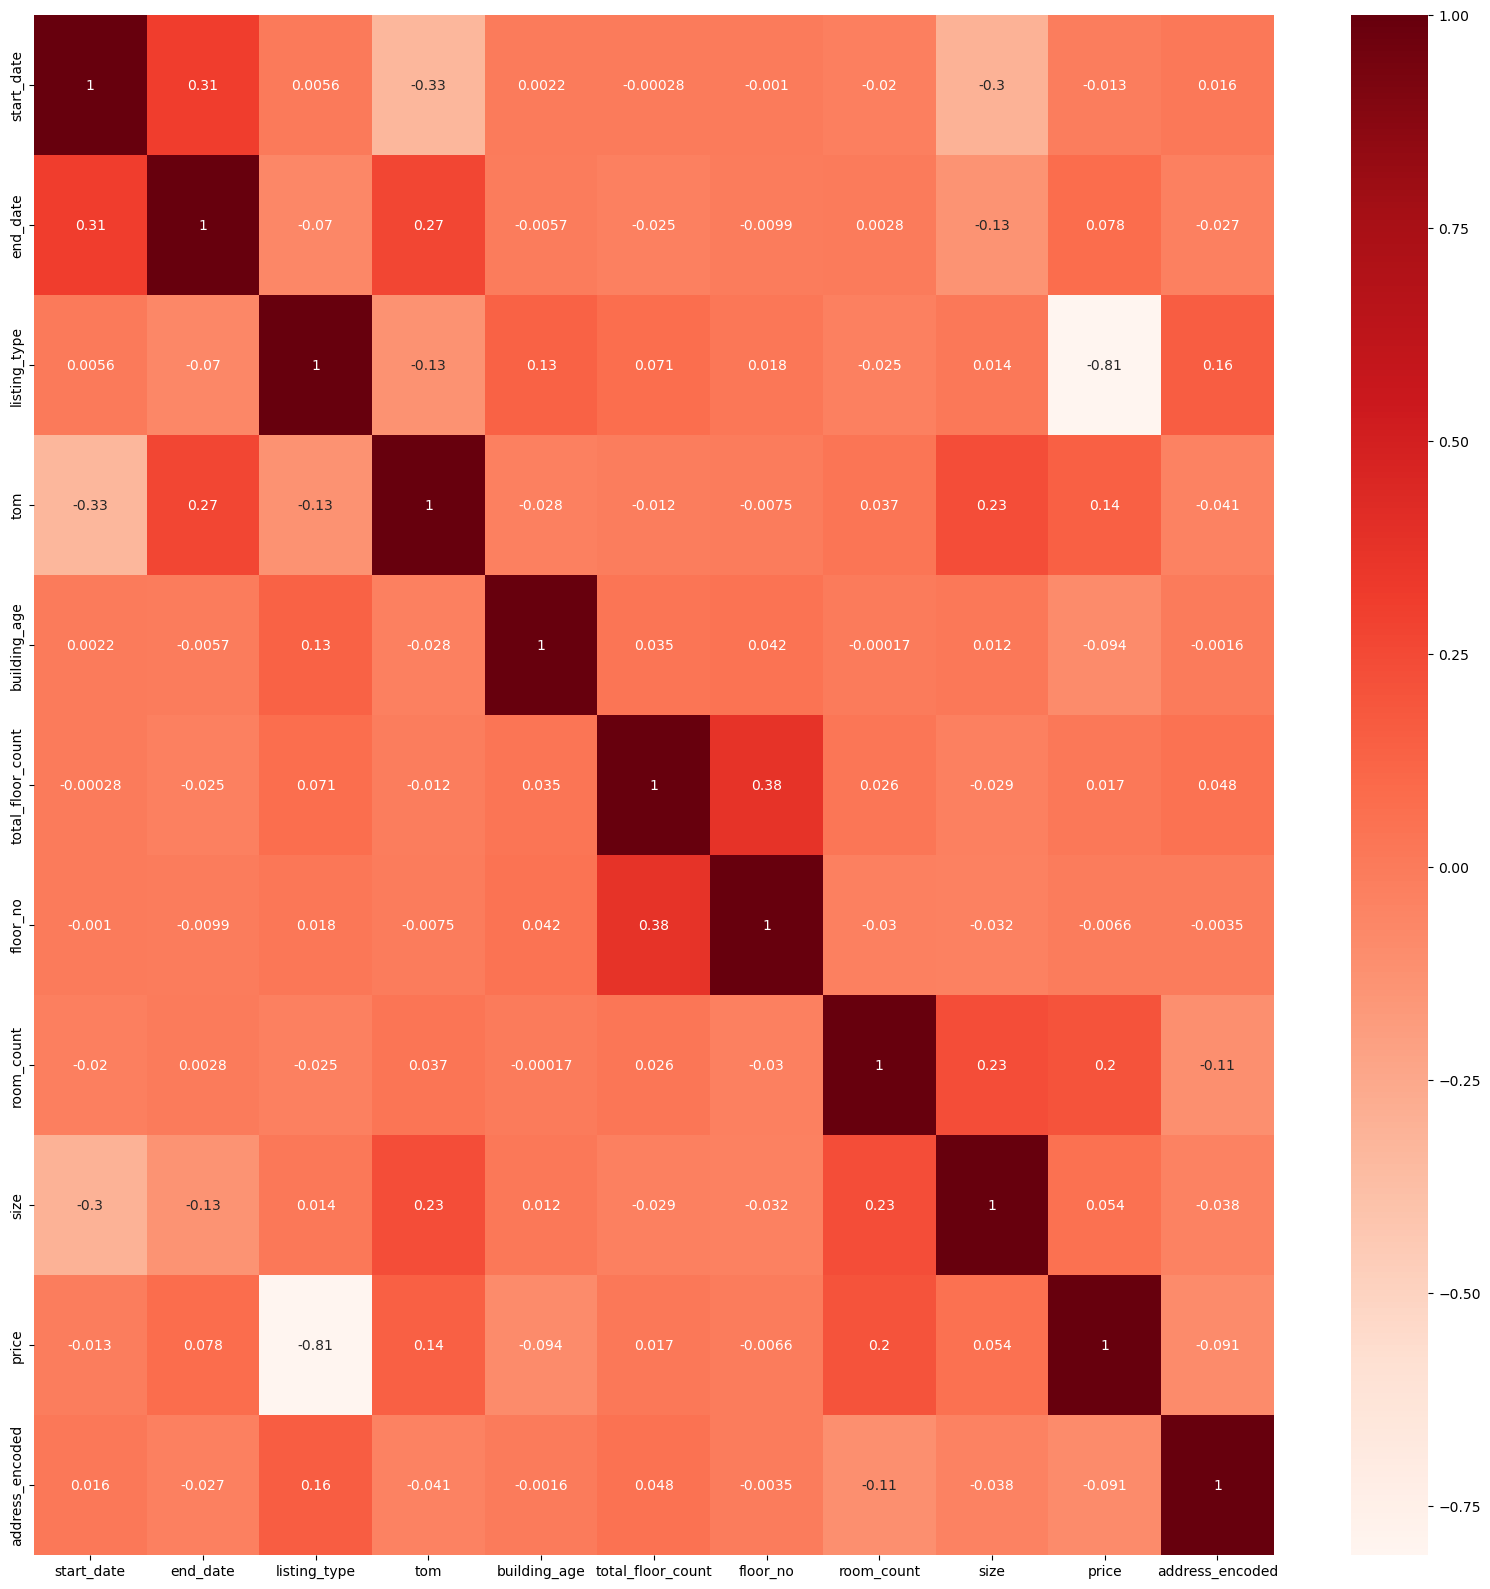

In [531]:
import matplotlib.pyplot as plt
import seaborn as sns

df_nums = df.select_dtypes(exclude=["object"])

plt.figure(figsize=(20, 20))
sns.heatmap(df_nums.corr(), annot=True, cmap='Reds')
plt.show()

Между признаками нет высокой корреляции, но есть неплохая корреляция между: 

__size и room_count__ (0.23), 

__floor_no и total_floor_count__ (0.38), 

__tom и end_date__ (0.27), 

__room_count и price__ (0.2)

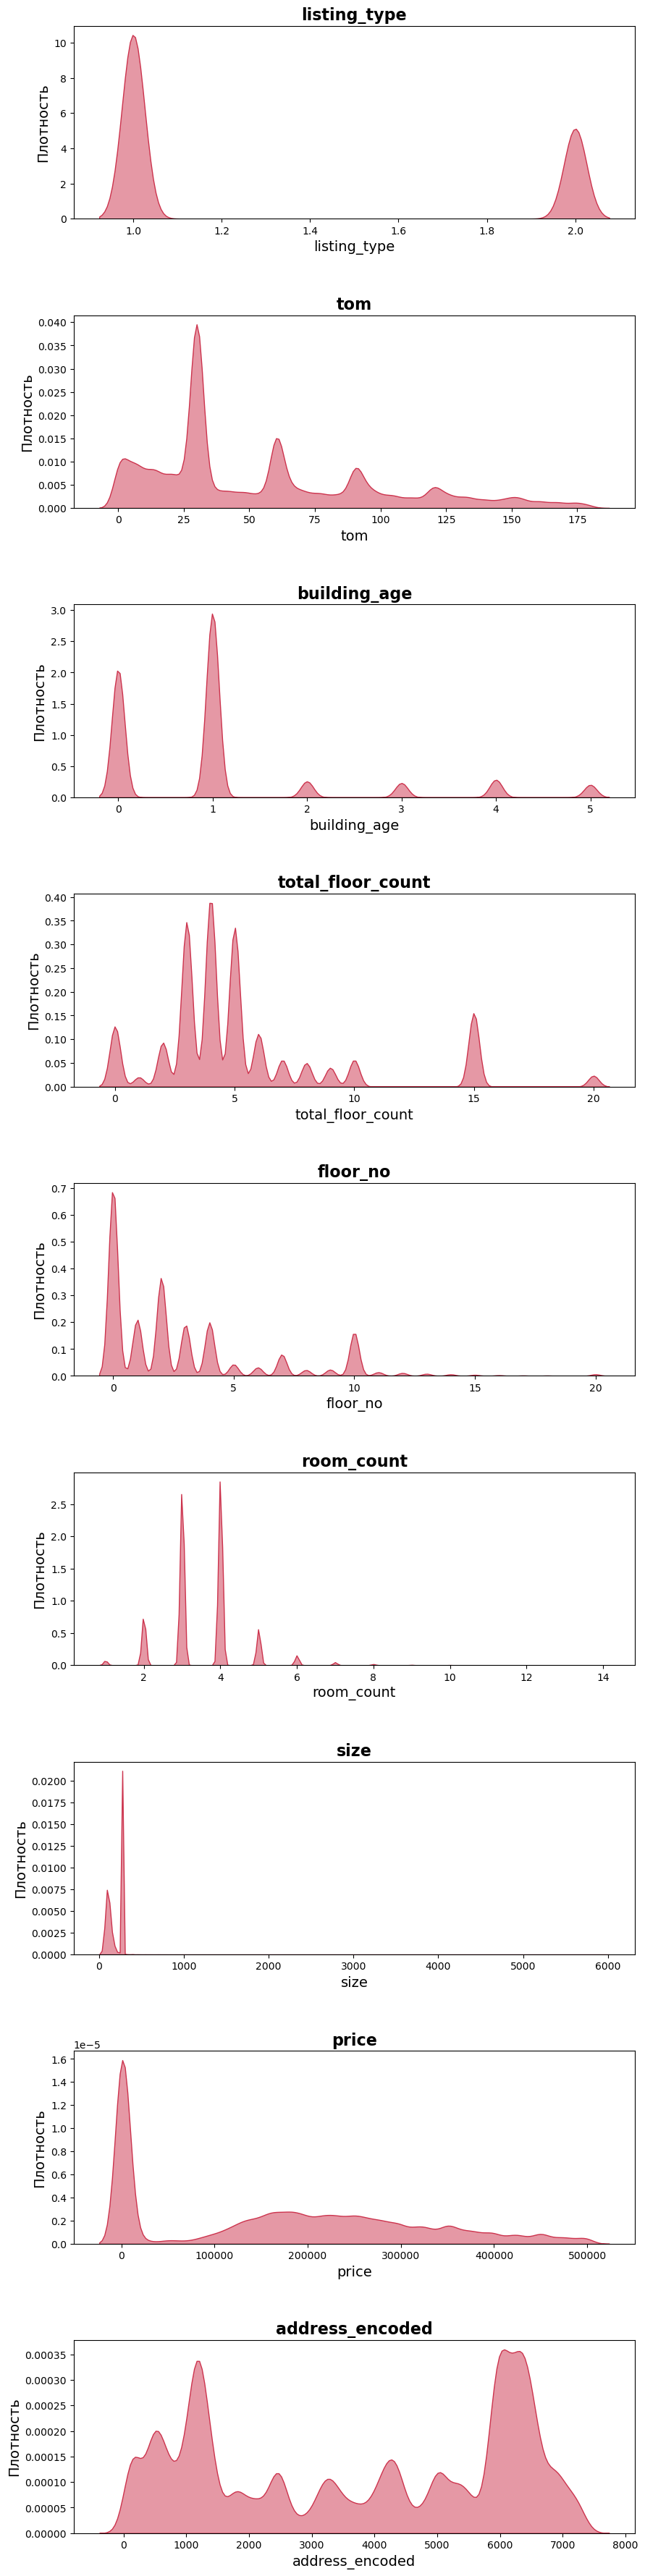

In [534]:
numeric_columns = df.select_dtypes(include=['number']).columns

fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(10, 5 * len(numeric_columns)))
plt.subplots_adjust(hspace=0.5)
if len(numeric_columns) == 1:
    axes = [axes]
for i, column in enumerate(numeric_columns):
    ax = axes[i]
    sns.kdeplot(
        data=df,
        x=column,
        fill=True,
        alpha=0.5,
        bw_adjust=0.7,
        color=[0.8, 0.2, 0.3],
        ax=ax
    )
    ax.set_title(column, fontweight='bold', fontsize=16)
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Плотность', fontsize=14)

plt.show()

In [535]:
df

,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,heating_type,price,address_encoded
0,Rezidans,2018-10-12,2019-09-01,2,30,0,20,2,3,90,Fancoil,3500.0,6301
1,Daire,2019-02-13,2025-09-01,1,14,0,20,20,1,43,Fancoil,490000.0,6301
2,Daire,2018-09-10,2018-08-11,1,30,0,1,10,3,279,Fancoil,155000.0,5314
6,Daire,2019-04-01,2025-09-01,2,54,0,20,14,4,160,Fancoil,3750.0,6301
11,Rezidans,2019-05-01,2019-01-18,2,13,2,20,20,4,165,Fancoil,7500.0,6703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403480,Daire,2018-09-25,2019-01-23,1,120,1,0,0,4,279,absent,185000.0,1165
403481,Daire,2019-12-01,2025-09-01,1,46,1,0,0,1,279,absent,354641.0,7096
403482,Daire,2018-09-18,2025-09-01,2,162,1,0,0,1,279,absent,1500.0,6477
403483,Daire,2018-11-10,2025-09-01,1,139,1,0,0,3,279,absent,120000.0,4838


## 4. Экспорт датасета

In [538]:
df.to_csv("dataset_house_prices.csv")

## 5. Обучение моделей 

# Классификация 

In [92]:
df = pd.read_csv('dataset_house_prices.csv')

In [94]:
df

,id,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,heating_type,price,address_encoded
0,0,Rezidans,2018-10-12,2019-09-01,2,30,0,20,2,3,90,Fancoil,3500.0,6301
1,1,Daire,2019-02-13,2025-09-01,1,14,0,20,20,1,43,Fancoil,490000.0,6301
2,2,Daire,2018-09-10,2018-08-11,1,30,0,1,10,3,279,Fancoil,155000.0,5314
3,6,Daire,2019-04-01,2025-09-01,2,54,0,20,14,4,160,Fancoil,3750.0,6301
4,11,Rezidans,2019-05-01,2019-01-18,2,13,2,20,20,4,165,Fancoil,7500.0,6703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347103,403480,Daire,2018-09-25,2019-01-23,1,120,1,0,0,4,279,absent,185000.0,1165
347104,403481,Daire,2019-12-01,2025-09-01,1,46,1,0,0,1,279,absent,354641.0,7096
347105,403482,Daire,2018-09-18,2025-09-01,2,162,1,0,0,1,279,absent,1500.0,6477
347106,403483,Daire,2018-11-10,2025-09-01,1,139,1,0,0,3,279,absent,120000.0,4838


In [13]:
#pip install catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/102.4 MB 787.7 kB/s eta 0:02:10
   ---------------------------------------- 0.2/102.4 MB 1.3 MB/s eta 0:01:19
   ---------------------------------------- 0.3/102.4 MB 1.6 MB/s eta 0:01:04
   ---------------------------------------- 0.4/102.4 MB 1.9 MB/s eta 0:00:55
   ---------------------------------------- 0.5/102.4 MB 2.1 MB/s eta 0:00:49
   ---------------------------------------- 0.9/102.4 MB 2.9 MB/s eta 0:00:35
   ---------------------------------------- 1.2/102.4 MB 3.3 MB/s eta 0:00:31
    --------------------------------------- 1.5/102.4 MB 3.6 MB/s eta 0:00:28
    --------------------------------------- 1.8/102.4 MB 3.9 MB/s eta 0:00:26
    --------------------------------------- 2.0/102.4 MB 4.1 MB/s eta 0:00:25
    --------------------------------------- 2.3/102.4 MB 4.2 MB/s eta 0:00:2

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [98]:
# Предобработка данных - ВАЖНО: преобразуем даты!
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

# Создаем числовые признаки из дат
df['start_year'] = df['start_date'].dt.year
df['start_month'] = df['start_date'].dt.month
df['start_day'] = df['start_date'].dt.day
df['end_year'] = df['end_date'].dt.year
df['end_month'] = df['end_date'].dt.month
df['end_day'] = df['end_date'].dt.day

# Удаляем оригинальные datetime столбцы
df = df.drop(['start_date', 'end_date'], axis=1)

In [100]:
le = LabelEncoder()
df['heating_type_ecnoded'] = le.fit_transform(df['heating_type'])
df = df.drop('heating_type', axis=1)

In [102]:
# Целевая переменная
y = df['sub_type']
X = df.drop(['sub_type', 'id'], axis=1)

In [104]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. BaggingClassifier (бэкинг)

In [107]:
print("=== BaggingClassifier ===")
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10),
    n_estimators=50,
    random_state=42
)
bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_bagging):.4f}")
print(classification_report(y_test, y_pred_bagging))

=== BaggingClassifier ===
Accuracy: 0.9514
                     precision    recall  f1-score   support

              Daire       0.96      1.00      0.98     64457
        Komple Bina       0.96      0.41      0.58       211
         Kooperatif       0.00      0.00      0.00        12
Köşk / Konak / Yalı       0.00      0.00      0.00        16
               Loft       0.00      0.00      0.00         3
        Müstakil Ev       0.67      0.45      0.54      1207
       Prefabrik Ev       0.74      0.59      0.66       133
           Rezidans       0.86      0.18      0.30      1047
              Villa       0.68      0.50      0.58      1414
       Yalı Dairesi       0.00      0.00      0.00        21
             Yazlık       0.55      0.31      0.40       854
        Çiftlik Evi       1.00      0.06      0.12        47

           accuracy                           0.95     69422
          macro avg       0.54      0.29      0.35     69422
       weighted avg       0.94      0.95

# 2. CatBoost (бустинг)

In [110]:
print("\n=== CatBoost ===")
catboost_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=0
)
catboost_clf.fit(X_train, y_train)
y_pred_catboost = catboost_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_catboost):.4f}")
print(classification_report(y_test, y_pred_catboost))


=== CatBoost ===
Accuracy: 0.9512
                     precision    recall  f1-score   support

              Daire       0.96      1.00      0.98     64457
        Komple Bina       0.95      0.49      0.65       211
         Kooperatif       0.00      0.00      0.00        12
Köşk / Konak / Yalı       0.00      0.00      0.00        16
               Loft       0.00      0.00      0.00         3
        Müstakil Ev       0.69      0.41      0.51      1207
       Prefabrik Ev       0.90      0.59      0.71       133
           Rezidans       0.76      0.16      0.26      1047
              Villa       0.66      0.55      0.60      1414
       Yalı Dairesi       0.00      0.00      0.00        21
             Yazlık       0.60      0.25      0.35       854
        Çiftlik Evi       1.00      0.06      0.12        47

           accuracy                           0.95     69422
          macro avg       0.54      0.29      0.35     69422
       weighted avg       0.94      0.95      0.

# 3. StackingClassifier (стеккинг)

In [115]:
print("\n=== StackingClassifier ===")
# Базовые модели
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=8, random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
]

# Мета-модель
meta_model = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}")
print(classification_report(y_test, y_pred_stacking))


=== StackingClassifier ===
Accuracy: 0.9452
                     precision    recall  f1-score   support

              Daire       0.96      0.99      0.98     64457
        Komple Bina       0.91      0.10      0.18       211
         Kooperatif       0.00      0.00      0.00        12
Köşk / Konak / Yalı       0.00      0.00      0.00        16
               Loft       0.00      0.00      0.00         3
        Müstakil Ev       0.60      0.37      0.46      1207
       Prefabrik Ev       0.53      0.35      0.43       133
           Rezidans       0.70      0.17      0.27      1047
              Villa       0.53      0.57      0.55      1414
       Yalı Dairesi       0.00      0.00      0.00        21
             Yazlık       0.57      0.04      0.08       854
        Çiftlik Evi       0.83      0.11      0.19        47

           accuracy                           0.95     69422
          macro avg       0.47      0.23      0.26     69422
       weighted avg       0.93      0.

# Сравнение результатов

In [118]:
print("\n=== Сравнение моделей ===")
print(f"Bagging Accuracy: {accuracy_score(y_test, y_pred_bagging):.4f}")
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_pred_catboost):.4f}")
print(f"Stacking Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}")


=== Сравнение моделей ===
Bagging Accuracy: 0.9514
CatBoost Accuracy: 0.9512
Stacking Accuracy: 0.9452


In [124]:
import pickle

# Сохраняем модель
with open('catboost_clf.pkl', 'wb') as file:
    pickle.dump(catboost_clf, file)

In [ ]:
# Загружаем модель позже
# with open('stacking_model.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

# # Используем загруженную модель
# predictions = loaded_model.predict(X_new_data)

# Регрессия

In [142]:
# pip install xgboost


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 435.7 kB/s eta 0:02:11
   ---------------------------------------- 0.1/56.8 MB 744.7 kB/s eta 0:01:17
   ---------------------------------------- 0.2/56.8 MB 1.4 MB/s eta 0:00:42
   ---------------------------------------- 0.3/56.8 MB 1.6 MB/s eta 0:00:36
   ---------------------------------------- 0.5/56.8 MB 1.8 MB/s eta 0:00:33
    --------------------------------------- 0.8/56.8 MB 2.8 MB/s eta 0:00:21
    --------------------------------------- 1.4/56.8 MB 3.9 MB/s eta 0:00:15
   - -------------------------------------- 2.1/56.8 MB 5.3 MB/s eta 0:00:11
   -- ------------------------------------- 3.2/56.8 MB 7.2 MB/s eta 0:00:08
   -- ------------------------------------- 4.2/56.8 MB 8.6 MB/s eta 0:00:07
   --- ------------------------------------ 5.0/56.8 MB 9.3 MB/s eta 0:00:06
   ---- 

In [144]:
from sklearn.ensemble import StackingRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [154]:
le = LabelEncoder()
df['sub_type_encoded'] = le.fit_transform(df['sub_type'])
df = df.drop('sub_type', axis=1)

In [156]:
y = df['price']
X = df.drop(['price', 'id'], axis=1)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. BaggingRegressor (бэкинг)

In [167]:
print("=== BaggingRegressor ===")
bagging_reg = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=10),
    n_estimators=50,
    random_state=42
)
bagging_reg.fit(X_train, y_train)
y_pred_bagging = bagging_reg.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_bagging):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_bagging):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_bagging)):.4f}")

=== BaggingRegressor ===
R² Score: 0.8212
MAE: 38783.1700
RMSE: 61072.6885


# 2. XGBoost (бустинг)

In [169]:
print("\n=== XGBoost ===")
xgb_reg = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='reg:squarederror'
)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.4f}")


=== XGBoost ===
R² Score: 0.8404
MAE: 37344.6095
RMSE: 57702.3856


# 3. StackingRegressor (стеккинг)

In [175]:
print("\n=== StackingRegressor ===")
# Базовые модели для стеккинга
base_models = [
    ('dt', DecisionTreeRegressor(max_depth=8, random_state=42)),
    ('lr', LinearRegression())
]

# Мета-модель
meta_model = LinearRegression()

stacking_reg = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)
stacking_reg.fit(X_train, y_train)
y_pred_stacking = stacking_reg.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_stacking):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_stacking):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_stacking)):.4f}")


=== StackingRegressor ===
R² Score: 0.7918
MAE: 42662.2657
RMSE: 65903.1065


# Сравнение результатов

In [176]:
print("\n=== Сравнение моделей ===")
print(f"Bagging R²: {r2_score(y_test, y_pred_bagging):.4f}")
print(f"XGBoost R²: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"Stacking R²: {r2_score(y_test, y_pred_stacking):.4f}")


=== Сравнение моделей ===
Bagging R²: 0.8212
XGBoost R²: 0.8404
Stacking R²: 0.7918


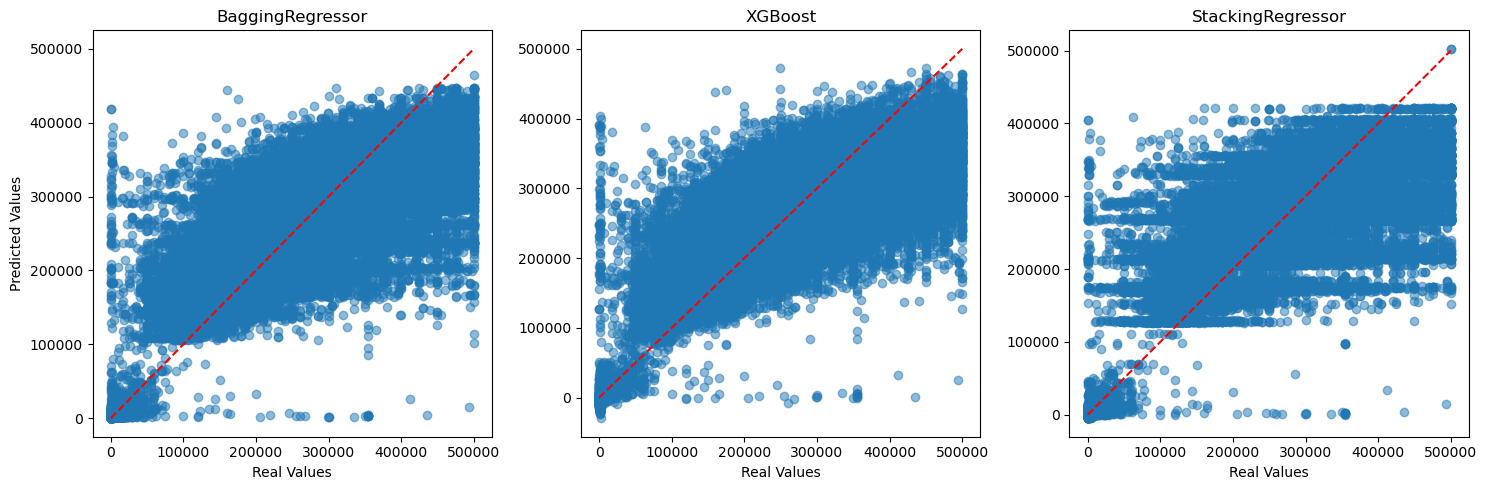

In [179]:
plt.figure(figsize=(15, 5))

# График предсказаний vs реальные значения
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_bagging, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('BaggingRegressor')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('XGBoost')
plt.xlabel('Real Values')

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('StackingRegressor')
plt.xlabel('Real Values')

plt.tight_layout()
plt.show()

In [181]:
with open('xgb_reg.pkl', 'wb') as file:
    pickle.dump(xgb_reg, file)